In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [5]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [6]:
raw_data.shape

(325, 335)

In [7]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [8]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [12]:
LR = labels["Risk"]=="LR"
HR = labels["Risk"]=="HR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"

In [16]:
HR_typical = labels[HR & typical]
HR_ASD = labels[HR & ASD]

In [18]:
analysis_labels = pd.concat((HR_typical, HR_ASD))
analysis_labels["ASD_DX_group"].value_counts()

TYPICAL    149
ASD         39
Name: ASD_DX_group, dtype: int64

In [19]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'TYPICAL'], dtype=object), array(['HR'], dtype=object)]

In [20]:
risk_labels = pd.Series(enc_labels[:,0], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.3)

print(train_data.shape)
train_labels.value_counts()

(131, 333)


1    104
0     27
dtype: int64

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

In [52]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    from keras.constraints import max_norm
    keras.backend.clear_session()
    
#     tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.01 # For L1 Reg
#     my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal()

    dnn.add(Dense(units = 256, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init,  kernel_constraint=max_norm(4)))
    dnn.add(keras.layers.Dropout(0.2)),
    dnn.add(Dense(units = 50, activation=activation,
                  kernel_initializer=he_init,  kernel_constraint=max_norm(4)))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init,  kernel_constraint=max_norm(4))) # 5 labels -> logits for now
    
    SGD=keras.optimizers.SGD(lr=0.001)
#     NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=SGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [47]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}_ASDvHR_relu_10_SGD'.format(time),
                          update_freq="epoch", write_graph=False)

In [48]:
%%time
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=500, batch_size=10, verbose=0, callbacks=[tensorboard])

CPU times: user 18.6 s, sys: 4.42 s, total: 23 s
Wall time: 9.7 s


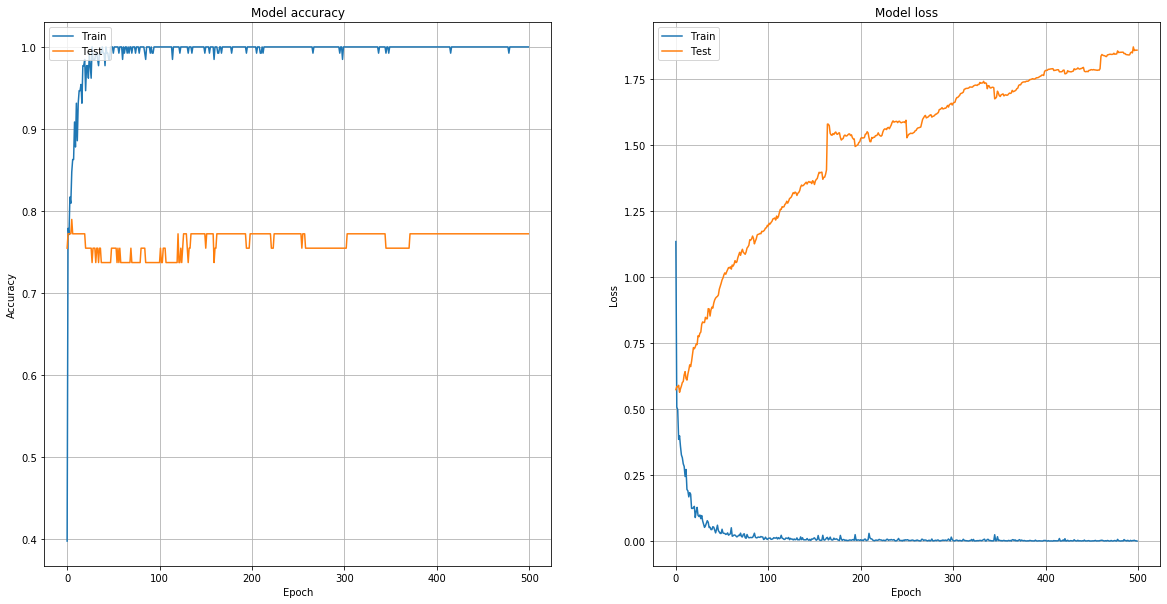

57/57 [==============================] - 0s 33us/step
Loss:1.862, Acc:0.7719


In [49]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

Confusion matrix, without normalization
[[0.         1.        ]
 [0.02222222 0.97777778]]
Overall Accuracy: 0.7719


(<matplotlib.axes._subplots.AxesSubplot at 0x1a38878a90>, array([[ 0, 12],
        [ 1, 44]]))

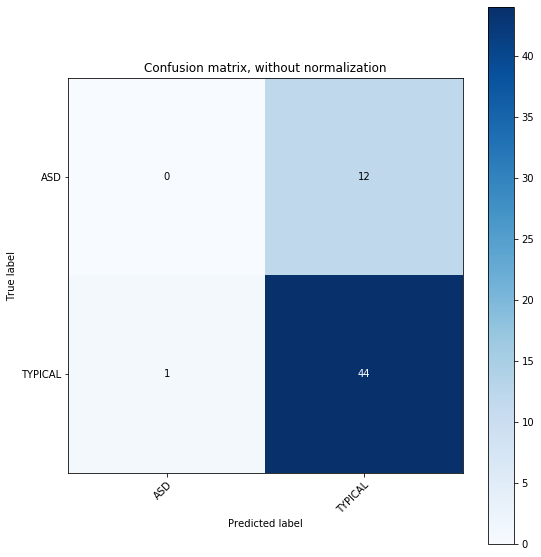

In [50]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[0])

In [51]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score, pos_label=0)

precision_score(y_true=np.ravel(y_valid), y_pred=y_pred, pos_label=0)

0.0

## Calculate LRP

In [30]:
val_samples = analysis_labels.loc[test_labels.index]
val_samples["DNN Pred"] = y_pred
val_samples[val_samples["Risk"]=="HR"]

,ASD_DX_group,Risk,DNN Pred
CandID,,,
526558,ASD,HR,1.0
950194,ASD,HR,1.0
321541,ASD,HR,0.0
857317,ASD,HR,0.0
751794,ASD,HR,1.0
677040,ATYPICAL_MULLEN,HR,0.0
402809,ASD,HR,0.0
389521,ASD,HR,0.0
456823,ASD,HR,0.0


In [31]:
_correct = np.logical_and(y_pred == np.ravel(y_valid) , (val_samples["Risk"]=="HR").values)
_labels = val_samples[_correct]["ASD_DX_group"].values

In [32]:
correct_HR_samples = X_valid[np.logical_and(y_pred == np.ravel(y_valid) , (val_samples["Risk"]=="HR").values)]

In [41]:
import innvestigate
import innvestigate.utils as iutils

analyzer_type = "pattern.attribution"
analyzer_kwargs = {
    "pattern.attribution":
        {"pattern_type":"relu"},
    "lrp.epsilon":
        {"epsilon":1e-3}
 }

model_wo_softmax = dnn
# model_wo_softmax = iutils.keras.graph.model_wo_softmax(dnn)

analyzer = innvestigate.create_analyzer(analyzer_type, model_wo_softmax,
                                        **analyzer_kwargs[analyzer_type])
analyzer.fit(X_train, batch_size=20, verbose=1, disable_no_training_warning=True)

Epoch 1/1
7/7 [==============================] - 0s 35ms/step - loss: 3.1500 - broadcast_4_loss: 1.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000


In [38]:
lrp = analyzer.analyze(correct_HR_samples)
# pd.DataFrame(relevance_results)
lrp.shape

(8, 333)

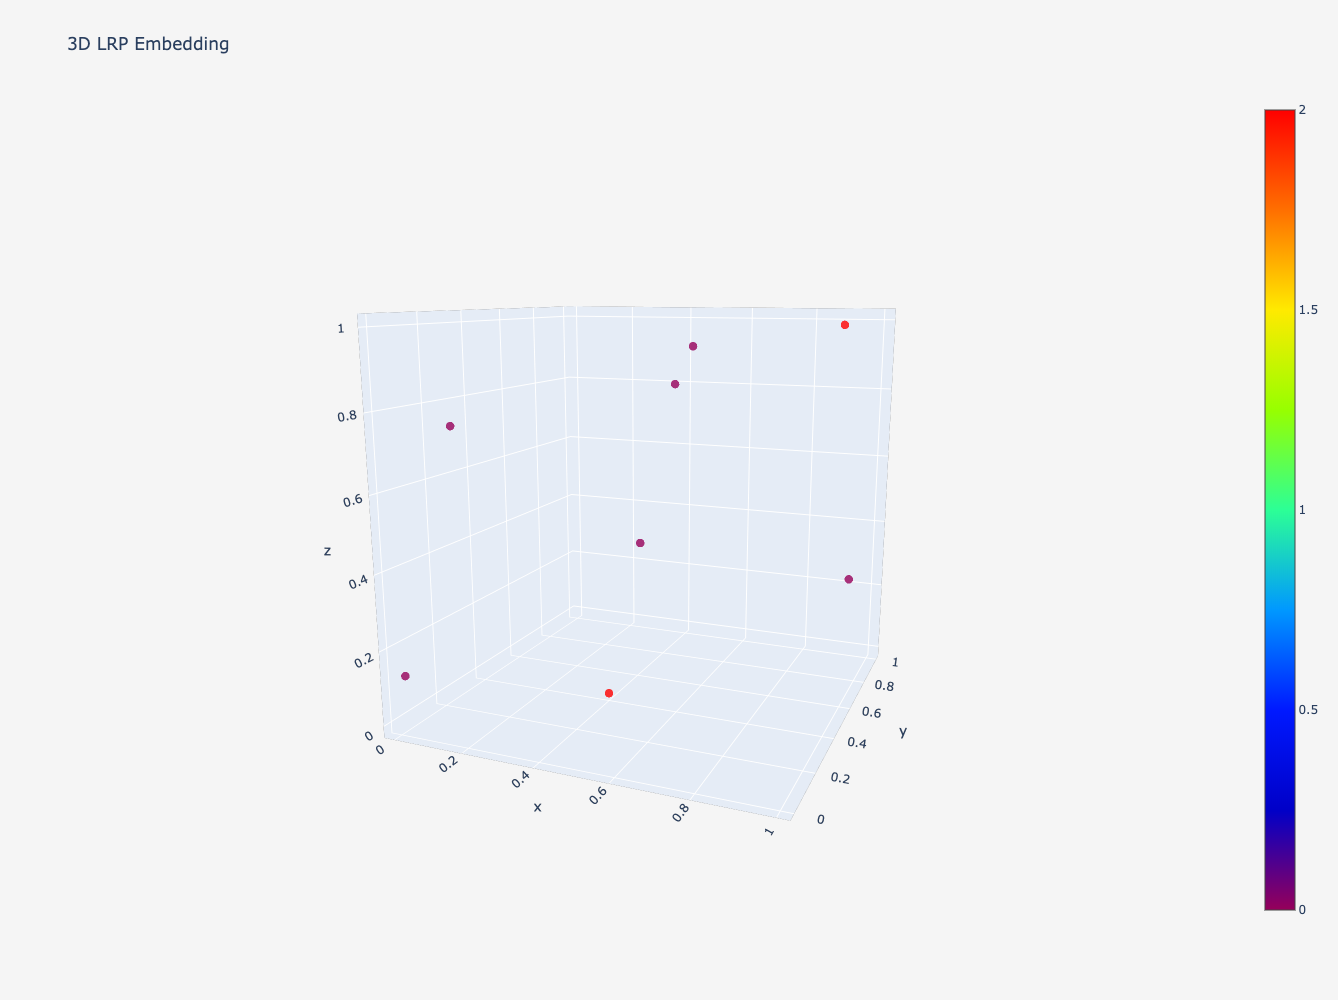

In [39]:
from sklearn.preprocessing import MinMaxScaler
from helper import plot_3d_lrp

reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=5,
                    min_dist=0)

reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
])

reducer_pipeline.fit(lrp)
embeddings = reducer_pipeline.transform(lrp)
plot_3d_lrp(embeddings, colors= enc.transform(_labels.reshape(-1,1))[:,0], labels=_labels )

### Cross Validating

In [30]:
# Separating a hold out set that will be used for validation of the pipeline
# train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.01)
train_data, train_labels, test_data, test_labels = data, risk_labels, [], []

In [31]:
risk_labels.value_counts()

1    149
0     39
dtype: int64

In [32]:
train_data.shape

(188, 333)

In [53]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [54]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.033, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 2ms/step
Scores on data set: loss=0.608 accuracy=0.8421
Fold Correct: 16
Running worker: 1
Fold: 1 -> Loss:0.039, Acc:0.9941
Prediction Accuracy
19/19 [==============================] - 0s 24us/step
Scores on data set: loss=0.894 accuracy=0.7368
Fold Correct: 14
Running worker: 2
Fold: 2 -> Loss:0.025, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 23us/step
Scores on data set: loss=0.377 accuracy=0.8421
Fold Correct: 16
Running worker: 3
Fold: 3 -> Loss:0.038, Acc:0.9882
Prediction Accuracy
19/19 [==============================] - 0s 34us/step
Scores on data set: loss=0.870 accuracy=0.7895
Fold Correct: 15
Running worker: 4
Fold: 4 -> Loss:0.030, Acc:0.9941
Prediction Accuracy
19/19 [==============================] - 0s 40us/step
Scores on data set: loss=1.223 accuracy=0.7368
Fold Correct: 14
Running worker: 5
Fo

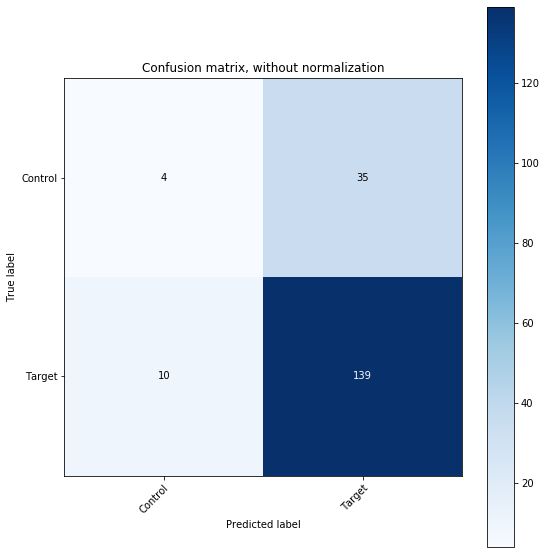

In [55]:
cm = pipeline.train_model(batch_size=int(10), epochs=500, cross_validation=True, parallel=False, verbose=0)

## SMOTE first and then classify

> ## All ASD samples are placed at the end of the array

In [88]:
RANDOM_STATE
print(risk_labels.value_counts())
print("===== Sanity Check =====:", all(risk_labels[risk_labels==0] == risk_labels[-(len(HR_ASD)):]))

1    149
0     39
dtype: int64
===== Sanity Check =====: True


In [91]:
data[149:]

,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,ROI09,ROI10,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
107524,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,57.548630,43.613918,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
138494,702.025696,257.664642,95.202927,161.633896,339.142120,544.074158,46.095768,187.924713,52.365986,52.923141,...,82.525490,95.847824,23.099915,186.457794,34.411999,1.548491,208.834030,25.436422,77.222084,15.240438
155712,795.377502,240.952698,196.493393,213.986206,314.419800,643.238892,52.760525,264.902863,28.139593,62.430672,...,60.877457,129.604446,29.433756,386.182373,91.552742,1.184271,243.952545,52.167412,52.148006,10.509195
160209,654.405029,294.765808,118.604721,141.655731,358.785553,673.647888,20.008690,102.040230,88.483322,46.659718,...,117.856651,100.702881,22.993984,200.810257,37.751736,1.881644,187.458466,25.237984,43.698730,10.281715
172993,529.401672,263.221863,160.010635,153.035706,405.158203,542.492798,72.212784,177.850952,29.584930,51.560764,...,51.007198,101.152344,14.840546,145.408356,34.443195,1.144495,214.314621,28.287136,51.267254,14.622266
174982,758.816345,442.528809,108.128662,151.116302,274.373566,619.112549,51.928787,238.683517,74.471985,67.038094,...,48.867573,141.627060,38.049244,346.767426,78.453850,1.226628,233.008820,18.408936,34.896164,19.120090
175448,683.035095,328.923462,152.153473,135.374893,528.213806,950.819275,19.733028,153.246414,41.818035,50.963200,...,71.731194,107.505737,25.234829,248.791992,65.016624,1.149353,242.369827,25.666527,58.102940,17.194536
271626,642.263428,122.374130,141.773788,144.200470,408.980347,321.423798,67.614288,210.585922,34.039520,60.738445,...,40.764210,112.748062,26.876722,210.709213,26.493038,0.912979,245.321655,27.572254,42.098404,14.919891
321541,687.414795,305.017090,129.026825,182.920334,474.471405,374.394928,70.260681,159.301346,77.089310,49.870731,...,65.227516,134.801910,31.581892,306.479797,78.961479,0.636462,192.420364,18.177507,24.950008,11.416089


In [61]:
from imblearn.over_sampling import SMOTE

synth_train, synth_y = SMOTE(random_state=RANDOM_STATE, k_neighbors=3).fit_resample(data,risk_labels) # Both are np arrays now

In [96]:
synth_train.shape

(298, 333)

In [92]:
synth_train[len(HR_typical):len(HR_typical)+len(HR_ASD)]

array([[518.3457031 , 311.0137939 , 118.7776337 , ...,  17.96138573,
         23.44036484,  14.53055763],
       [702.0256958 , 257.6646423 ,  95.20292664, ...,  25.43642235,
         77.22208405,  15.24043751],
       [795.3775024 , 240.9526978 , 196.4933929 , ...,  52.1674118 ,
         52.14800644,  10.50919533],
       ...,
       [933.4680176 , 271.4142456 , 148.1113892 , ...,  34.62413788,
         52.94664001,  12.85360527],
       [583.7315674 , 310.213623  , 100.8837357 , ...,  16.35919571,
         20.0045414 ,  11.96832275],
       [767.0294189 , 488.8855896 , 134.025528  , ...,  29.10937881,
         36.10884857,  15.40684414]])

In [99]:
num_synths=len(data)-len(synth_train)
num_synths

-110

In [97]:
synth_samples = pd.DataFrame((synth_train[len(HR_typical)+len(HR_ASD):]),index=)
synth_samples

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
0,681.959544,279.420115,179.296476,131.060501,424.424836,619.104182,46.671059,180.392090,28.100171,62.323375,...,80.641994,121.229494,21.736134,219.648968,46.300525,1.479926,250.823066,27.960548,32.745146,14.771461
1,779.296469,279.143081,150.156493,150.339773,427.407365,544.704695,29.617299,150.984774,54.881513,56.755046,...,45.792315,99.277028,20.324129,192.068940,41.701157,0.905107,217.231994,20.103305,34.812005,17.441114
2,819.465480,261.052197,149.893565,159.224046,399.038619,594.604442,24.189074,146.131577,57.393515,57.478831,...,46.745756,104.109025,20.282331,190.894814,39.546991,0.781301,233.125553,20.017632,32.474915,16.253035
3,555.941037,288.541801,161.178271,146.866719,431.936390,504.977575,65.814938,178.050238,35.086963,50.797106,...,49.689160,101.441515,17.622310,159.814628,40.120537,1.202629,197.325392,25.668171,47.066586,14.810970
4,593.079761,331.134046,153.296000,139.736926,479.333263,439.933027,47.448872,170.101318,45.624587,49.499738,...,45.442018,102.249051,19.392015,225.684785,51.648367,1.258223,172.676318,22.271923,43.125403,14.024455
5,559.118185,219.901005,164.736037,177.269271,455.695734,491.390812,46.551023,156.551395,41.450050,42.363866,...,33.557873,91.752655,12.156212,273.658310,43.711135,0.882134,212.733919,25.693291,39.778368,11.776675
6,613.255984,249.324004,153.406959,186.349635,637.652520,639.833781,35.775723,204.756340,27.183149,65.265737,...,55.804757,95.311608,13.924516,179.543474,57.901597,0.935929,218.765818,31.651569,49.331841,14.518769
7,773.155835,258.353581,187.722823,198.436651,356.708900,704.079220,46.227586,242.816880,30.845230,60.162371,...,63.024359,125.233255,28.603195,359.006141,86.303818,1.177364,243.639479,46.925457,53.325910,11.831576
8,660.783068,237.195116,163.687541,141.721951,411.776580,710.815310,49.990652,136.874533,29.419948,61.995765,...,81.175187,116.349190,24.905837,229.061096,53.845974,1.655424,267.513963,32.420161,30.647687,13.509740
9,604.355590,333.249700,162.982518,136.290170,480.380941,438.558220,54.473598,179.182675,45.046170,49.574919,...,47.456169,102.365316,22.647467,185.534060,49.980159,1.302820,167.165852,21.013375,39.676643,15.182889


In [37]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
smote_pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.009, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 2ms/step
Scores on data set: loss=0.821 accuracy=0.6842
Fold Correct: 13
Running worker: 1
Fold: 1 -> Loss:0.016, Acc:0.9963
Prediction Accuracy
19/19 [==============================] - 0s 43us/step
Scores on data set: loss=1.134 accuracy=0.6842
Fold Correct: 13
Running worker: 2
Fold: 2 -> Loss:0.016, Acc:0.9963
Prediction Accuracy
19/19 [==============================] - 0s 33us/step
Scores on data set: loss=0.934 accuracy=0.7895
Fold Correct: 15
Running worker: 3
Fold: 3 -> Loss:0.013, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 30us/step
Scores on data set: loss=1.582 accuracy=0.7368
Fold Correct: 14
Running worker: 4
Fold: 4 -> Loss:0.012, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 27us/step
Scores on data set: loss=1.223 accuracy=0.7895
Fold Correct: 15
Running worker: 5
Fo

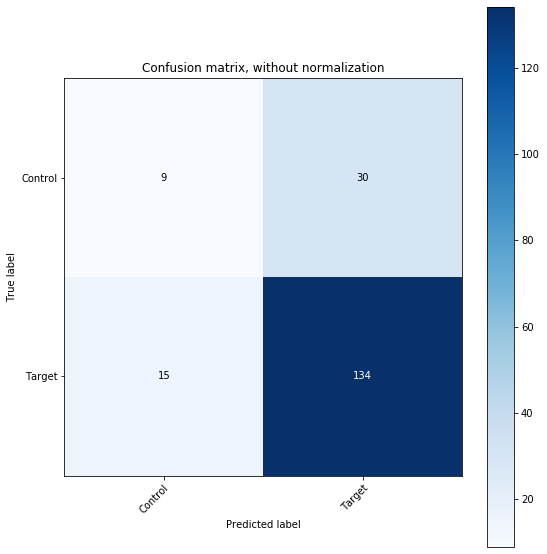

In [38]:
cm = smote_pipeline.train_model(batch_size=int(10), epochs=500, cross_validation=True,
                                parallel=False, verbose=0, smote=True)

In [56]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 8,
                    n_neighbors=6,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False, class_label = 0)
print("Clusters Found:", max(pipeline.clusterer.labels_)+1)

LRP Shape:  (10, 333)
Cluster Search Space: range(3, 9)
Minimum Size:
Clusters                  (3, 3)
Noise                     (3, 3)
Halkidi                   (3, 3)
Halkidi-Filtered Noise    (3, 3)
dtype: object
Clusters Found: 0


In [57]:
np.max(pipeline.training_lrp)

0.64014184

In [58]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
reindexed_labels.shape

(138,)

In [59]:
_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]
# enc.transform(correct_HR)[:,0]

In [60]:
plot_3d_lrp(pipeline.training_lrp, colors=pipeline.clusterer.labels_, labels=correct_HR["ASD_DX_group"])

NameError: name 'plot_3d_lrp' is not defined

In [252]:
correct_HR["DNN Clusters"] = pipeline.clusterer.labels_
correct_HR

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,ASD_DX_group,Risk,DNN Clusters
CandID,,,
107524,ASD,HR,2
792210,ATYPICAL_ADOS,HR,0
983222,ASD,HR,2
550654,ATYPICAL_ADOS,HR,1
155712,ASD,HR,-1
174982,ASD,HR,-1
490878,ASD,HR,2
963368,ATYPICAL_ADOS,HR,0
336576,ASD,HR,0


In [85]:
orig_labels = analysis_labels.loc[reindexed_labels.index]
orig_labels["DNN Pred"] = pipeline.predictions
orig_HR = orig_labels[orig_labels["Risk"]=="HR"]

In [86]:
orig_HR.head()

,ASD_DX_group,Risk,DNN Pred
CandID,,,
107524,ASD,HR,0.0
172993,ASD,HR,1.0
364612,ASD,HR,1.0
792210,ATYPICAL_ADOS,HR,0.0
916595,ASD,HR,1.0


In [52]:
_counts=[]
names=[]
for name, subgroup in orig_HR.groupby(by="ASD_DX_group"):
    names.append(name)
    _cnt = subgroup["DNN Pred"].value_counts()
    _counts.append([_cnt[0.0], _cnt[1.0]])
#     print(name, subgroup["DNN Pred"].value_counts(), sep="\n")

dnn_predictions = pd.DataFrame(_counts, columns=["Correct","Incorrect"], index=names)
dnn_predictions

,Correct,Incorrect
ASD,11,24


In [54]:
norm_pred = dnn_predictions.div(dnn_predictions.sum(axis=1), axis="index")

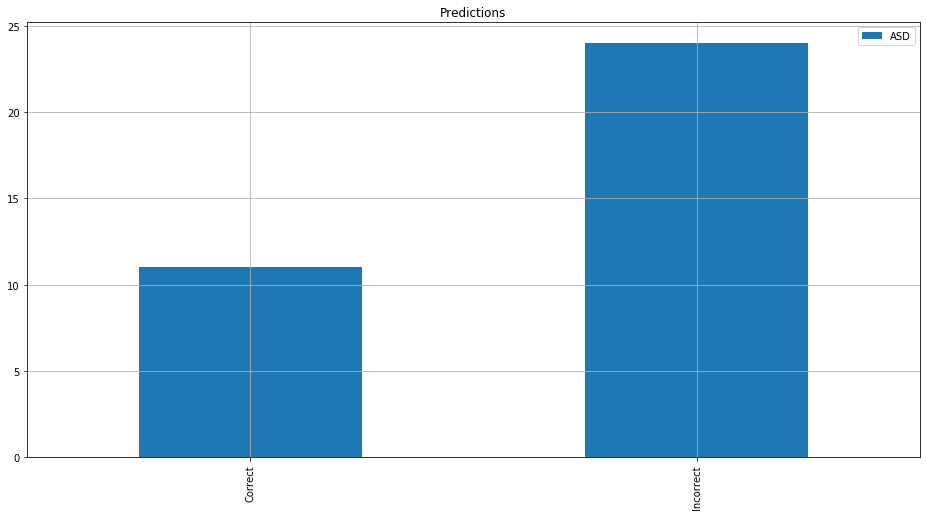

In [56]:
dnn_predictions.T.plot(kind="bar", figsize=(16,8), grid=True, title="Predictions")